In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits

%matplotlib inline

In [59]:
# Load the image data from a FITS file
with fits.open("image.fit") as hdul:
    hdul.info()
    image_data = hdul[0].data

# Normalize the image data
print(f"Data type: {image_data.dtype}, Data shape: {image_data.shape}")

# Convert the data to float32 for safe normalization
data = image_data.astype(np.float32)

# Calculate the minimum and maximum values of the data
data_min = np.min(image_data)
data_max = np.max(image_data)

# Normalize the data to the range [0, 1]
image_data = (image_data - data_min) / (data_max - data_min)

Filename: image.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      48   (3008, 3008, 3)   int16 (rescales to uint16)   


Data type: uint16, Data shape: (3, 3008, 3008)


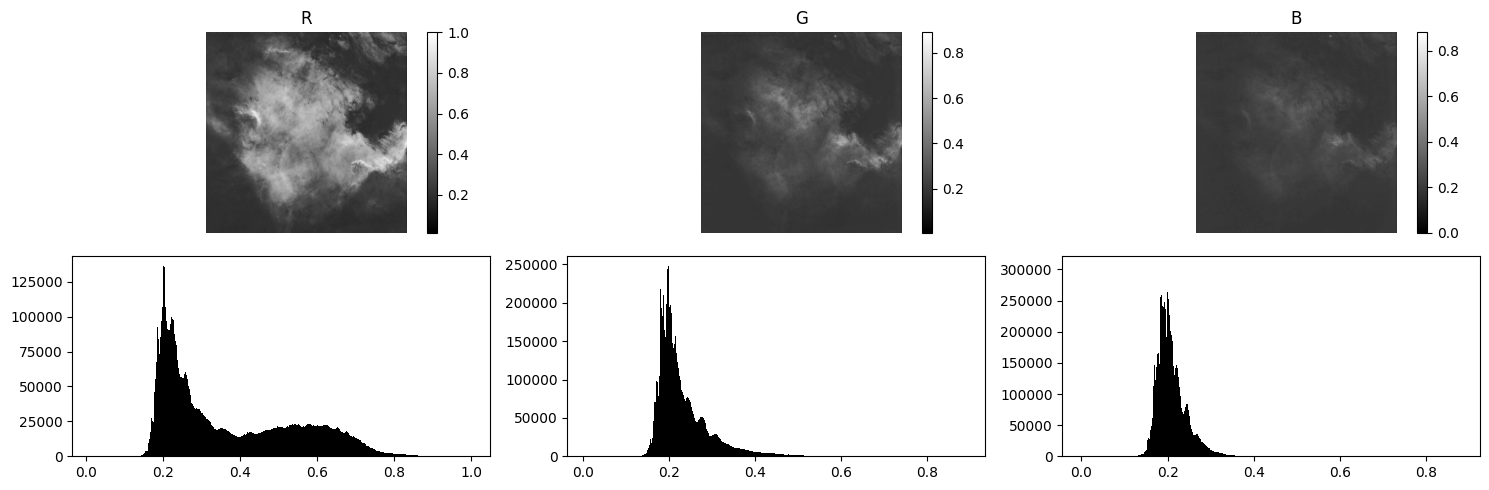

In [60]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 5))

for i, channel in zip(range(3), ['R', 'G', 'B']):
    # Plot the channel image
    data = image_data[i]
    im = axes[0, i].imshow(data, cmap='gray')
    axes[0, i].set_title(channel)
    axes[0, i].axis('off')
    fig.colorbar(im, ax=axes[0, i])

    # Plot the histogram below the image
    axes[1, i].hist(data.flatten(), bins=512, color='black')

plt.tight_layout()
plt.show()

In [61]:
def stats(data):
    # Create a DataFrame to display the results
    stats_df = pd.DataFrame({
        'Min': np.min(data, axis=(1, 2)),
        'Max': np.max(data, axis=(1, 2)),
        'Mean': np.mean(data, axis=(1, 2)),
        'MAD': np.array([np.mean(np.abs(data[i] - np.mean(data[i]))) for i in range(data.shape[0])]),
        'Stdev': np.std(data, axis=(1, 2))
    }, index=[f'Dataset {i+1}' for i in range(data.shape[0])])
    print(stats_df)

In [62]:
stats(image_data)

                Min       Max      Mean       MAD     Stdev
Dataset 1  0.013915  1.000000  0.369508  0.153299  0.174432
Dataset 2  0.006900  0.890112  0.230438  0.044520  0.060507
Dataset 3  0.000000  0.880005  0.208825  0.025617  0.033998


In [63]:
blk_p_adj = 1.0
blk_p = np.min(image_data, axis=(1, 2)) + blk_p_adj * (
    np.mean(image_data, axis=(1, 2)) - np.min(image_data, axis=(1, 2))
)
print(blk_p)

disp = np.std(image_data, axis=(1, 2)) + np.mean(image_data, axis=(1, 2)) - blk_p
print(disp)

[0.36950765 0.23043842 0.20882513]
[0.17443227 0.06050718 0.03399776]


In [94]:
def rescale(arr, new_min, new_max):
    """
    Rescale an array of values to a new range [new_min, new_max].

    This function normalizes the input array's values from their original range
    [orig_min, orig_max] to a new specified range [new_min, new_max].

    Parameters:
    - arr (numpy array): The input array containing the values to be rescaled.
    - new_min (float): The new minimum value in the output range.
    - new_max (float): The new maximum value in the output range.

    Returns:
    - numpy array: The array with values rescaled to the new range [new_min, new_max].
    """

    # Determine the original minimum and max values of the array
    orig_min = np.min(arr)
    orig_max = np.max(arr)

    # Avoid division by zero in case orig_min and orig_max are the same (constant array)
    if orig_max == orig_min:
        # If the array has a constant value, return an array filled with new_min
        return np.full_like(arr, new_min)

    # Normalize the array to the range [0, 1] and then scale and shift it to [new_min, new_max]
    # (arr - orig_min) shifts the data such that orig_min becomes 0
    # (orig_max - orig_min) scales the data to fit in the range [0, 1]
    # (new_max - new_min) rescales this range to [0, new_max-new_min]
    # new_min shifts the result to start from new_min
    return new_min + (arr - orig_min) * (new_max - new_min) / (orig_max - orig_min)

def mtf(x, m):
    """
    Midtones Transfer Function for PixelMath translation.

    Parameters:
    - x: The input pixel values or array.
    - m: The midtones adjustment value (equivalent to `E1`).

    Returns:
    - Adjusted pixel values.
    """
    return ((x + (m - x) * m) / m) ** (1 / m)

def complement(value):
    return 1 - value

In [98]:
boost = 1.0
channel = image_data[1]

a0 = disp / (1.0-blk_p[1])
e1 =  (a0[1] * (1 - a0[0]) / (a0[1] - 2 * a0[1] * a0[0] + a0[0])) / boost
e2 = rescale(channel, blk_p[1], 1.0)
e3 = complement(complement(mtf(e1, e2)) * complement(np.minimum(channel, blk_p[1])))


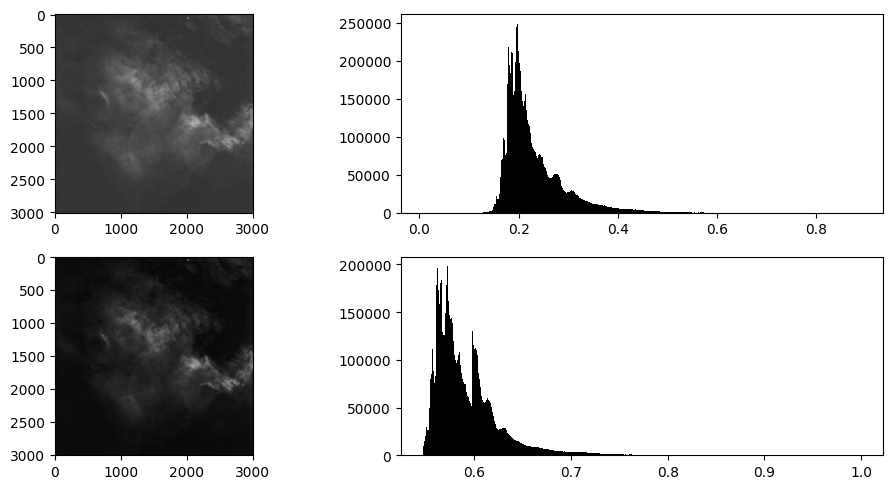

In [99]:
fig, axes = plt.subplots(2, 2,figsize=(10, 5))
axes[0, 0].imshow(channel, cmap='gray')
axes[0, 1].hist(channel.flatten(), bins=512, color='black')
axes[1, 0].imshow(e3, cmap='gray')
axes[1, 1].hist(e3.flatten(), bins=512, color='black')
plt.tight_layout()
plt.show()